In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality_with_index

import core.config as conf

In [2]:
client

Client Scheduler: tcp://127.0.0.1:37855 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


In [4]:
NP = 16
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00000'
ori_df = read_data(data_path)

print('number of rows:',len(ori_df))

IndexError: list index out of range

In [ ]:
columns = ['engaged_with_user_id', 
           'enaging_user_id',
           'language']
df = ori_df[columns]

In [10]:
df.head()

,engaged_with_user_id,enaging_user_id,language
0,3FFFAB69DC3055DE9DF4DCE5DEADF524,0D67ACC4DF718CAECE69F68D441F4BFB,2F548E5BE0D7F678E72DDE31DFBEF8E7
1,B37C1AF7D06A26C2E6FF79FF5AC7C2A0,7116A43B31AB25C175556E0367DD0D1B,2573A3CF633EBE6932A1E1010D5CD213
2,B988B59F3A2632147C44FF48EEE00896,3EFC5766CA40FDAC6DC93AA0391722BB,B8B04128918BBF54E2E178BFF1ABA833
3,4E850496C7884D1CB28018059A9C0F85,75B865DB04106FB5BEC6790197634748,B8B04128918BBF54E2E178BFF1ABA833
4,766EC621668260F335C7813926E95CE7,62D02B5DE77FA1086CDF443BF788317C,E7F038DE3EAD397AEC9193686C911677


In [12]:
df,language_index, _ = factorize_small_cardinality_with_index(df, "language", "language_encode")

In [13]:
language_index

,index,language
0,0,00304D7356D6C64481190D708D8F739C
1,1,0BB2C843174730BA7D958C98B763A797
2,2,105008E45831ADE8AF1DB888319F422A
3,3,10C6C994C2AD434F9D49D4BE9CFBC613
4,4,159541FA269CA8A9CDB93658CAEC4CA2
...,...,...
61,61,E7F038DE3EAD397AEC9193686C911677
62,62,E84BE2C963852FB065EE827F41A0A304
63,63,F33767F7D7080003F403FDAB34FEB755
64,64,F70598172AC4514B1E6818EA361AD580


In [14]:
df.head()

,engaged_with_user_id,enaging_user_id,language,language_encode
0,3B0AC695A63DC7D40BAEA9CCE3A62F8C,4D8B73FA556BF78D06F5DC94D6A23D11,1F73BB863A39DB62B4A55B7E558DB1E8,5
1,80A928D256E9F0A2EA26E3260C3FA417,09209EF8E2AD91357B856B0201A2D4FF,488B32D24BD4BB44172EB981C1BCA6FA,19
2,100FA5145EE20B418153A214D5609E98,2182E6EC38666C86C8E3F15B87B4346A,E7F038DE3EAD397AEC9193686C911677,61
3,63B1F99ED8084C3C488FAF88C845FF18,24915CAE1FE0161D19637430B3CC2881,8729EBF694C3DAF61208A209C2A542C8,36
4,7AA0B9E550DC337091B2A2DC571E5F8F,F318538CE6C6A6E1F2638524A0BD5E0F,E7F038DE3EAD397AEC9193686C911677,61


In [15]:
df = df.drop("language", axis = 1)

In [16]:
user_df = df[["engaged_with_user_id"]]

In [17]:
user_a = df["engaged_with_user_id"]
user_b = df["enaging_user_id"]
user_df = dask.dataframe.concat([user_a, user_b], axis = 0).unique().to_frame()

In [18]:
user_df = user_df.rename(columns = {0:"user"})

In [19]:
user_df, user_index, _ = factorize_small_cardinality_with_index(user_df, "user", "user_encode")

In [20]:
user_df.head()

,user,user_encode
0,00FC09E310FCE7A02226E6DAA697E01E,13600
1,00FC473B60E06E93A701F80E10FC9D31,13616
2,00FC36F6C9A219D3066C3CC1B497E33C,13608
3,00FC63F4317F2232F138438B51DAE3C2,13624
4,00FC115877B75BAE9E6C72DAC34AFECD,13601


In [21]:
df = df.merge(user_index, left_on="engaged_with_user_id", right_on = "user", how='left')

In [22]:
df.head()

,engaged_with_user_id,enaging_user_id,language_encode,index,user
0,BAD7A9C681AB8810F889473A3E914358,D05A0751C7642CDC2C39AAAB6B28E73D,19,2562969,BAD7A9C681AB8810F889473A3E914358
1,B22E5AB889E070066CDAB6A0E8C29B19,FFB14610C5B5DF733204DA60BEE36BA9,46,2444128,B22E5AB889E070066CDAB6A0E8C29B19
2,00FE1BBBF5A2B419BC69E6A2947529AD,D0ADDFB626BA08CF18341C9182E4E480,61,13716,00FE1BBBF5A2B419BC69E6A2947529AD
3,D1FE9B5C8293545377098315DD997415,87FA36F3580431145E910A23D25DC1AA,19,2881084,D1FE9B5C8293545377098315DD997415
4,DAF2C6380FB400011670CCAA02C89CE2,706C8294FE8C3F5D977BCB045C7BAE40,33,3004540,DAF2C6380FB400011670CCAA02C89CE2


In [23]:
df = df.drop("user", axis = 1)
df = df.rename(columns = {"index" : "engaged_user_encode"})

In [24]:
df = df.merge(user_index, left_on="enaging_user_id", right_on = "user", how='left')

In [25]:
df = df.drop("user", axis = 1)
df = df.rename(columns = {"index" : "engaging_user_encode"})

In [26]:
df = df.drop(["engaged_with_user_id", "enaging_user_id"], axis = 1)

In [27]:
df = df.repartition(npartitions=NP)
df, = dask.persist(df)

In [28]:
df.head()

,language_encode,engaged_user_encode,engaging_user_encode
0,40,807660,382046
1,19,2297000,3470705
2,36,388652,3411597
3,48,589961,1894844
4,19,3054185,1306164


In [109]:
language_df = pd.DataFrame(index=list(range(len(user_index))))
language_df = cudf.DataFrame(language_df)
language_df = dask_cudf.from_cudf(language_df, npartitions=16)
language_df, = dask.persist(language_df)
_ = wait(language_df)
language_df["tmp"] = 0

### engaged language

In [110]:
for i in range(66) :
    engaged_tmp = df[["engaged_user_encode", "language_encode"]][df["language_encode"]==i]
    engaged_tmp = engaged_tmp.groupby("engaged_user_encode").count().head()
    language_df = language_df.merge(engaged_tmp, left_index=True, right_index=True, how='left').astype(np.int32)
    language_df = language_df.rename(columns = {"language_encode":i})


100%|██████████| 66/66 [00:14<00:00,  4.44it/s]


In [114]:
language_df = language_df.drop("tmp", axis = 1)
language_df = language_df.fillna(0)

In [115]:
language_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
del engaged_tmp

### engaging language

In [117]:
egg_language_df = pd.DataFrame(index=list(range(len(user_index))))
egg_language_df = cudf.DataFrame(egg_language_df)
egg_language_df = dask_cudf.from_cudf(egg_language_df, npartitions=16)
egg_language_df, = dask.persist(egg_language_df)
_ = wait(egg_language_df)
egg_language_df["tmp"] = 0

In [118]:
for i in range(66) :
    engaging_tmp = df[["engaging_user_encode", "language_encode"]][df["language_encode"]==i]
    engaging_tmp = engaging_tmp.groupby("engaging_user_encode").count().head()
    egg_language_df = egg_language_df.merge(engaging_tmp, left_index=True, right_index=True, how='left').astype(np.int32)
    egg_language_df = egg_language_df.rename(columns = {"language_encode":i})


100%|██████████| 66/66 [00:14<00:00,  4.51it/s]


In [119]:
egg_language_df = egg_language_df.drop("tmp", axis =1)
egg_language_df = egg_language_df.fillna(0)

In [120]:
language_df = language_df + egg_language_df

In [121]:
del engaging_tmp 
del egg_language_df

In [122]:
language_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
languages = language_df.columns

In [129]:
language_df.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
count_columns = [f'count_language_{language}_occurence' for language in languages]
language_df.columns = [f'count_language_{language}_occurence' for language in languages]
language_df[count_columns]

,count_language_0_occurence,count_language_1_occurence,count_language_2_occurence,count_language_3_occurence,count_language_4_occurence,count_language_5_occurence,count_language_6_occurence,count_language_7_occurence,count_language_8_occurence,count_language_9_occurence,count_language_10_occurence,count_language_11_occurence,count_language_12_occurence,count_language_13_occurence,count_language_14_occurence,count_language_15_occurence,count_language_16_occurence,count_language_17_occurence,count_language_18_occurence,count_language_19_occurence,count_language_20_occurence,count_language_21_occurence,count_language_22_occurence,count_language_23_occurence,count_language_24_occurence,count_language_25_occurence,count_language_26_occurence,count_language_27_occurence,count_language_28_occurence,count_language_29_occurence,count_language_30_occurence,count_language_31_occurence,count_language_32_occurence,count_language_33_occurence,count_language_34_occurence,count_language_35_occurence,count_language_36_occurence,count_language_37_occurence,count_language_38_occurence,count_language_39_occurence,count_language_40_occurence,count_language_41_occurence,count_language_42_occurence,count_language_43_occurence,count_language_44_occurence,count_language_45_occurence,count_language_46_occurence,count_language_47_occurence,count_language_48_occurence,count_language_49_occurence,count_language_50_occurence,count_language_51_occurence,count_language_52_occurence,count_language_53_occurence,count_language_54_occurence,count_language_55_occurence,count_language_56_occurence,count_language_57_occurence,count_language_58_occurence,count_language_59_occurence,count_language_60_occurence,count_language_61_occurence,count_language_62_occurence,count_language_63_occurence,count_language_64_occurence,count_language_65_occurence
npartitions=276,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32
8795,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500509,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512726,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [131]:
know_language_columns = [f'know_language_{language}' for language in languages]
for language in languages:   
    language_df[f'know_language_{language}'] = language_df[f'count_language_{language}_occurence'] > 0
language_df[know_language_columns]

,know_language_0,know_language_1,know_language_2,know_language_3,know_language_4,know_language_5,know_language_6,know_language_7,know_language_8,know_language_9,know_language_10,know_language_11,know_language_12,know_language_13,know_language_14,know_language_15,know_language_16,know_language_17,know_language_18,know_language_19,know_language_20,know_language_21,know_language_22,know_language_23,know_language_24,know_language_25,know_language_26,know_language_27,know_language_28,know_language_29,know_language_30,know_language_31,know_language_32,know_language_33,know_language_34,know_language_35,know_language_36,know_language_37,know_language_38,know_language_39,know_language_40,know_language_41,know_language_42,know_language_43,know_language_44,know_language_45,know_language_46,know_language_47,know_language_48,know_language_49,know_language_50,know_language_51,know_language_52,know_language_53,know_language_54,know_language_55,know_language_56,know_language_57,know_language_58,know_language_59,know_language_60,know_language_61,know_language_62,know_language_63,know_language_64,know_language_65
npartitions=276,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
8795,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3500509,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512726,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [132]:
language_df.head()

,count_language_0_occurence,count_language_1_occurence,count_language_2_occurence,count_language_3_occurence,count_language_4_occurence,count_language_5_occurence,count_language_6_occurence,count_language_7_occurence,count_language_8_occurence,count_language_9_occurence,...,know_language_56,know_language_57,know_language_58,know_language_59,know_language_60,know_language_61,know_language_62,know_language_63,know_language_64,know_language_65
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [133]:
language_df['total_count_language_occurence'] = language_df[count_columns].sum(axis=1)
language_df['total_count_language_occurence']

<dask_cudf.Series | 134040 tasks | 276 npartitions>

In [134]:
language_df['total_known_language'] = language_df[know_language_columns].sum(axis=1)
language_df['total_known_language']

<dask_cudf.Series | 134868 tasks | 276 npartitions>

### How many languages does users know?

In [135]:
language_df.head()

,count_language_0_occurence,count_language_1_occurence,count_language_2_occurence,count_language_3_occurence,count_language_4_occurence,count_language_5_occurence,count_language_6_occurence,count_language_7_occurence,count_language_8_occurence,count_language_9_occurence,...,know_language_58,know_language_59,know_language_60,know_language_61,know_language_62,know_language_63,know_language_64,know_language_65,total_count_language_occurence,total_known_language
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,0,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,0,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,0,0
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,0,0
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,0,0


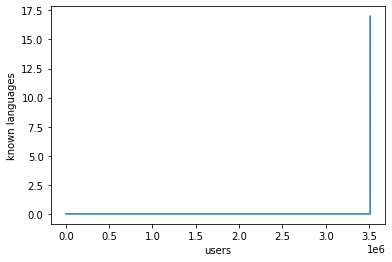

In [164]:
plt.plot(language_df['total_known_language'].compute().sort_values().to_array())
plt.xlabel("users")
plt.ylabel("known languages")

plt.show()

In [168]:
%%time
sum_df = language_df.sum().compute()

CPU times: user 4min 12s, sys: 849 ms, total: 4min 13s
Wall time: 11min 30s


In [169]:
sum_df_know_language = sum_df[know_language_columns]
sum_df_count_occurence = sum_df[count_columns]

### How many users know a certain language?


In [184]:
type(sum_df_know_language)

cudf.core.series.Series

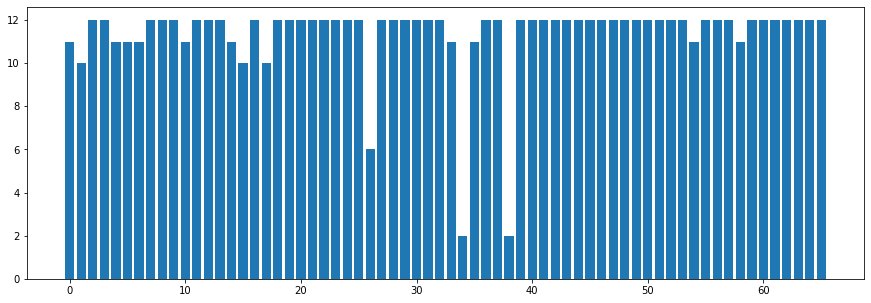

In [187]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_know_language.values.tolist()
plt.bar(idx, values)

plt.show()

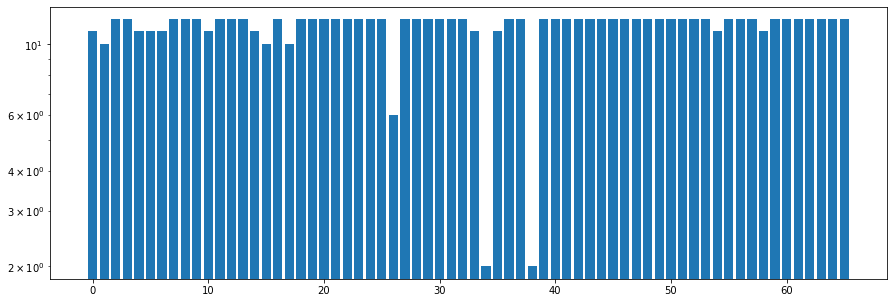

In [188]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')
idx = languages
values = sum_df_know_language.values.tolist()
plt.bar(idx, values)

plt.show()

### How many times the language has been interacted with?

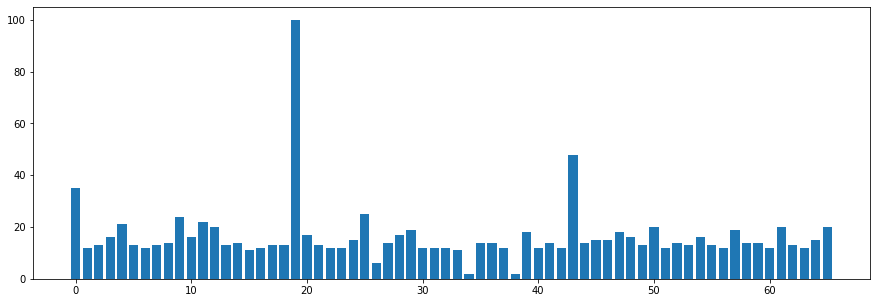

In [190]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()

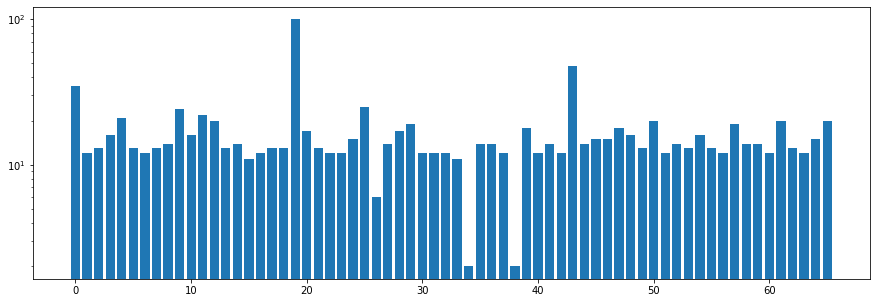

In [191]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')
idx = languages
values = sum_df_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()

## Let's consider the people that know only one language

How many are them?
How many interactions have they made in that language?


In [196]:
sum_df_user_that_know_1_language = language_df[language_df['total_known_language'] == 1].sum().compute()
sum_df_user_that_know_1_know_language = sum_df_user_that_know_1_language[know_language_columns]
sum_df_user_that_know_1_count_occurence = sum_df_user_that_know_1_language[count_columns]

KeyboardInterrupt: 

know_language_0     4.0
know_language_1     4.0
know_language_2     5.0
know_language_3     3.0
know_language_4     1.0
                   ... 
know_language_61    4.0
know_language_62    6.0
know_language_63    3.0
know_language_64    4.0
know_language_65    4.0
Length: 66, dtype: float64


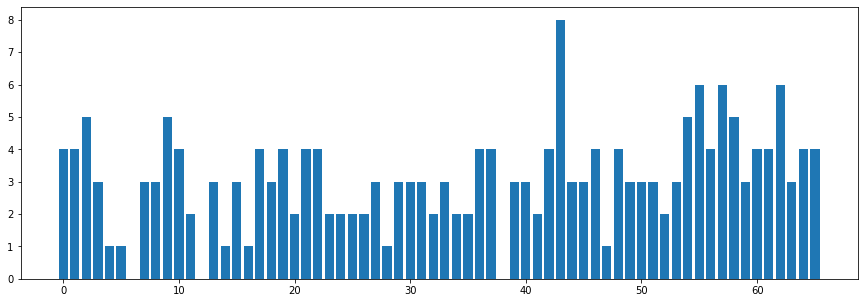

count_language_0_occurence     5.0
count_language_1_occurence     4.0
count_language_2_occurence     6.0
count_language_3_occurence     3.0
count_language_4_occurence     1.0
                              ... 
count_language_61_occurence    6.0
count_language_62_occurence    6.0
count_language_63_occurence    3.0
count_language_64_occurence    4.0
count_language_65_occurence    6.0
Length: 66, dtype: float64


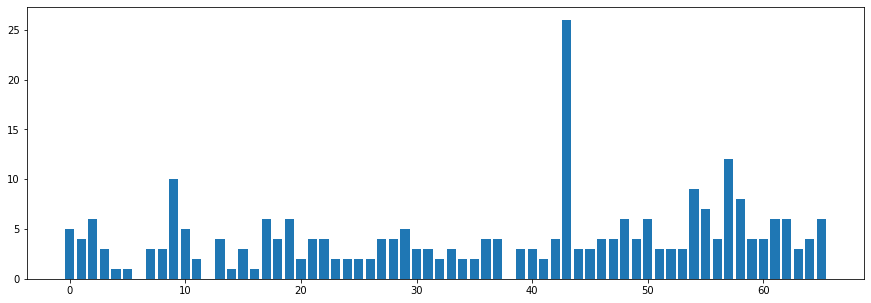

In [197]:
plt.rcParams['figure.figsize'] = [15, 5]
print(sum_df_user_that_know_1_know_language)
idx = languages
values = sum_df_user_that_know_1_know_language.values.tolist()
plt.bar(idx, values)

plt.show()


plt.rcParams['figure.figsize'] = [15, 5]
print(sum_df_user_that_know_1_count_occurence)
idx = languages
values = sum_df_user_that_know_1_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()


### Plot the percentage uf users that knows only one language with respect to the overall amount of users that know that language

## How to read the following bar chart

~70% of users that know japanese only know japanese (language 0)
~30% of users that know korean only know korean (language 5)

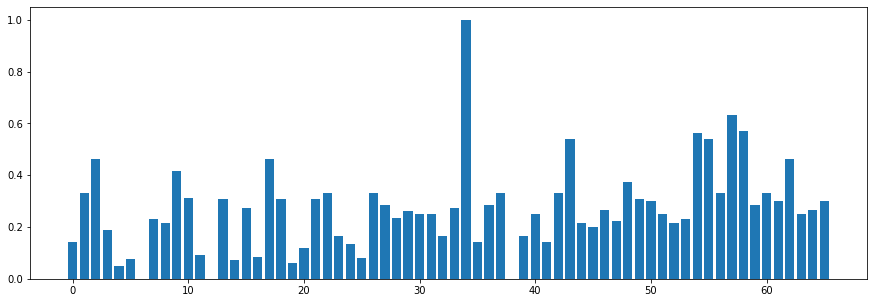

In [200]:
idx = languages
values = (sum_df_user_that_know_1_count_occurence/sum_df_count_occurence).values.tolist()
plt.bar(idx, values)
plt.show()


## Let's consider only the multilingual users

So just only those ones that have interacted with 2 or more languages


In [201]:
%%time
sum_df_user_that_know_2_or_more_languages = language_df[language_df['total_known_language'] >= 2].sum().compute()

CPU times: user 4min 8s, sys: 1.56 s, total: 4min 10s
Wall time: 11min 28s


In [202]:
sum_df_user_that_know_2_or_more_languages_know_language = sum_df_user_that_know_2_or_more_languages[know_language_columns]
sum_df_user_that_know_2_or_more_languages_count_occurence = sum_df_user_that_know_2_or_more_languages[count_columns]

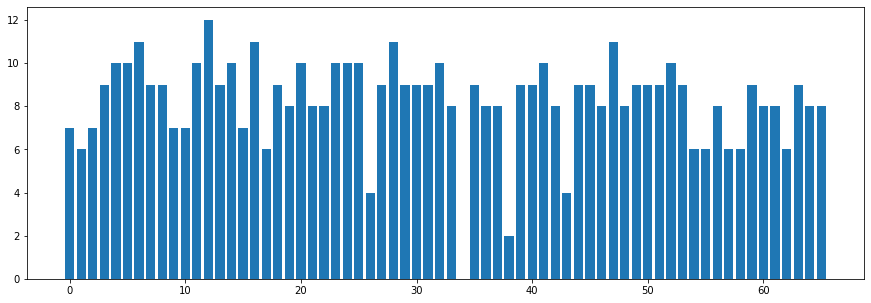

In [203]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_user_that_know_2_or_more_languages_know_language.values.tolist()
plt.bar(idx, values)

plt.show()

<BarContainer object of 66 artists>

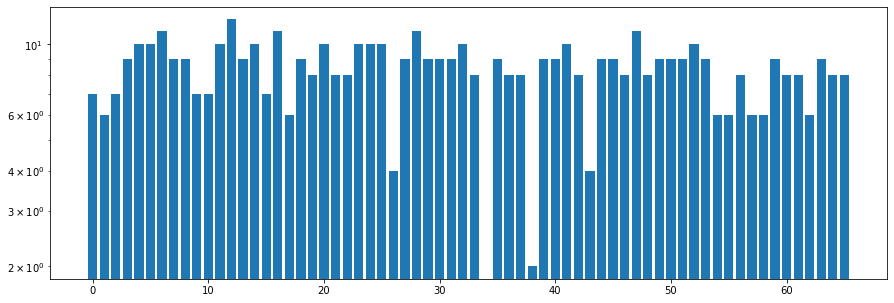

In [204]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')

idx = languages
values = sum_df_user_that_know_2_or_more_languages_know_language.values.tolist()
plt.bar(idx, values)


### Among the multilingual, how many a language has been used?

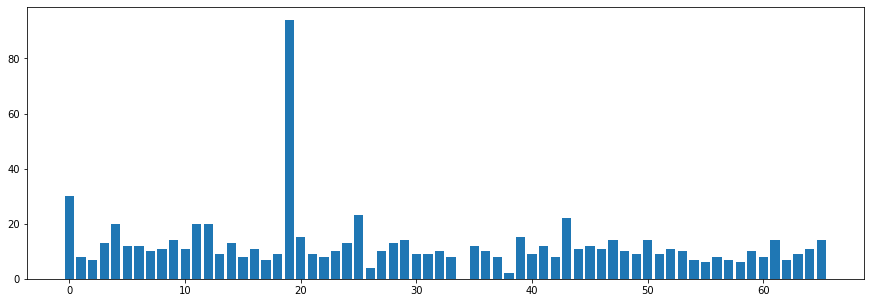

In [205]:
plt.rcParams['figure.figsize'] = [15, 5]
idx = languages
values = sum_df_user_that_know_2_or_more_languages_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()

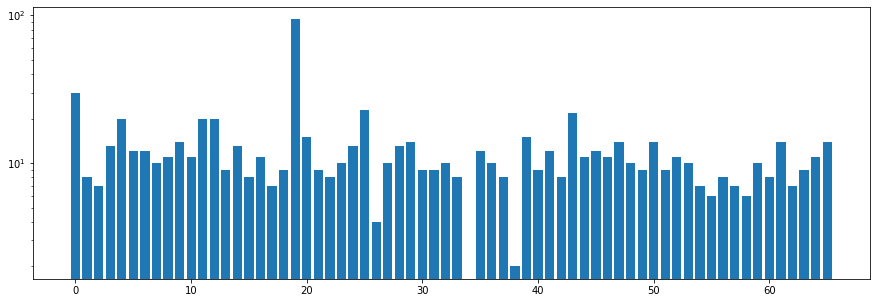

In [206]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.yscale('log')
idx = languages
values = sum_df_user_that_know_2_or_more_languages_count_occurence.values.tolist()
plt.bar(idx, values)

plt.show()